In [1]:
import pandas as pd
import os
import numpy as np
import librosa.display
import IPython
import matplotlib.pyplot as plt
import librosa
from scipy.io.wavfile import read as read_wav
import seaborn as sns
import torchaudio


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def load_data_to_df(data_dir='shords_dataset/'):
    data = []
    for cl in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, cl)
        for file in os.listdir(class_dir):
            if file.endswith('wav'):
                file_path = os.path.join(class_dir, file)
                data.append({'file_path': file_path, 'class': cl})
    df = pd.DataFrame(data)
    return df

In [7]:
def play_audio(path):
    sampling_rate, data=read_wav(path)
    return IPython.display.Audio(path, rate = sampling_rate)

def print_single_spectrogram(path, title=None):
    sample_rate, data = read_wav(path)
    if data.ndim == 2:  # If stereo, convert to mono
        mono = (data[:, 0] + data[:, 1]) / 2
    else:  # If mono
        mono = data
    
    plt.figure(figsize=(10, 4))
    plt.specgram(mono, Fs=sample_rate, NFFT=1024, noverlap=512, cmap='inferno')
    plt.title(title if title else 'Spectrogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read as read_wav

def print_single_waveform(path, title=None):
    sample_rate, data = read_wav(path)
    if data.ndim == 2:  # If stereo, convert to mono
        mono = (data[:, 0] + data[:, 1]) / 2
    else:
        mono = data
    time = np.linspace(0, len(mono) / sample_rate, num=len(mono))
    
    plt.figure(figsize=(10, 4))
    plt.plot(time, mono)
    plt.title(title if title else 'Waveform')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.show()

# Example usage:
# plot_single_waveform('path_to_your_audio_file.wav', title='Waveform')


In [9]:
data = load_data_to_df()

In [10]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=30)
    features = {
        'mfcc': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0),
        'chroma': np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0),
        'spectral_contrast': np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0),
        'zero_crossing_rate': np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0),
        'rms': np.mean(librosa.feature.rms(y=y).T, axis=0)
    }
    return features

features_list = []

for index, row in data.iterrows():
    features = extract_features(row['file_path'])
    features['class'] = row['class']
    features_list.append(features)
features_df = pd.DataFrame(features_list)


In [11]:

def print_multi_spectrogram(df, n):
    df_minor = df[df['class'] == 'minor'].sample(n=n)
    df_major = df[df['class'] == 'major'].sample(n=n)

    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(15, n * 5))

    for i, (index, row) in enumerate(df_minor.iterrows()):
        sample_rate, data = read_wav(row['file_path'])
        if data.ndim == 2:  # If stereo, convert to mono
            mono = (data[:, 0] + data[:, 1]) / 2
        else:  # If mono
            mono = data
        axes[i, 0].specgram(mono, Fs=sample_rate, NFFT=1024, noverlap=512, cmap='inferno')
        axes[i, 0].set_title(f"Minor - Sample {i+1}")
        axes[i, 0].set_ylabel('Frequency [Hz]')
        axes[i, 0].set_xlabel('Time [sec]')

    for i, (index, row) in enumerate(df_major.iterrows()):
        sample_rate, data = read_wav(row['file_path'])
        if data.ndim == 2:  # If stereo, convert to mono
            mono = (data[:, 0] + data[:, 1]) / 2
        else:  # If mono
            mono = data
        axes[i, 1].specgram(mono, Fs=sample_rate, NFFT=1024, noverlap=512, cmap='inferno')
        axes[i, 1].set_title(f"Major - Sample {i+1}")
        axes[i, 1].set_ylabel('Frequency [Hz]')
        axes[i, 1].set_xlabel('Time [sec]')

    plt.tight_layout()
    plt.show()

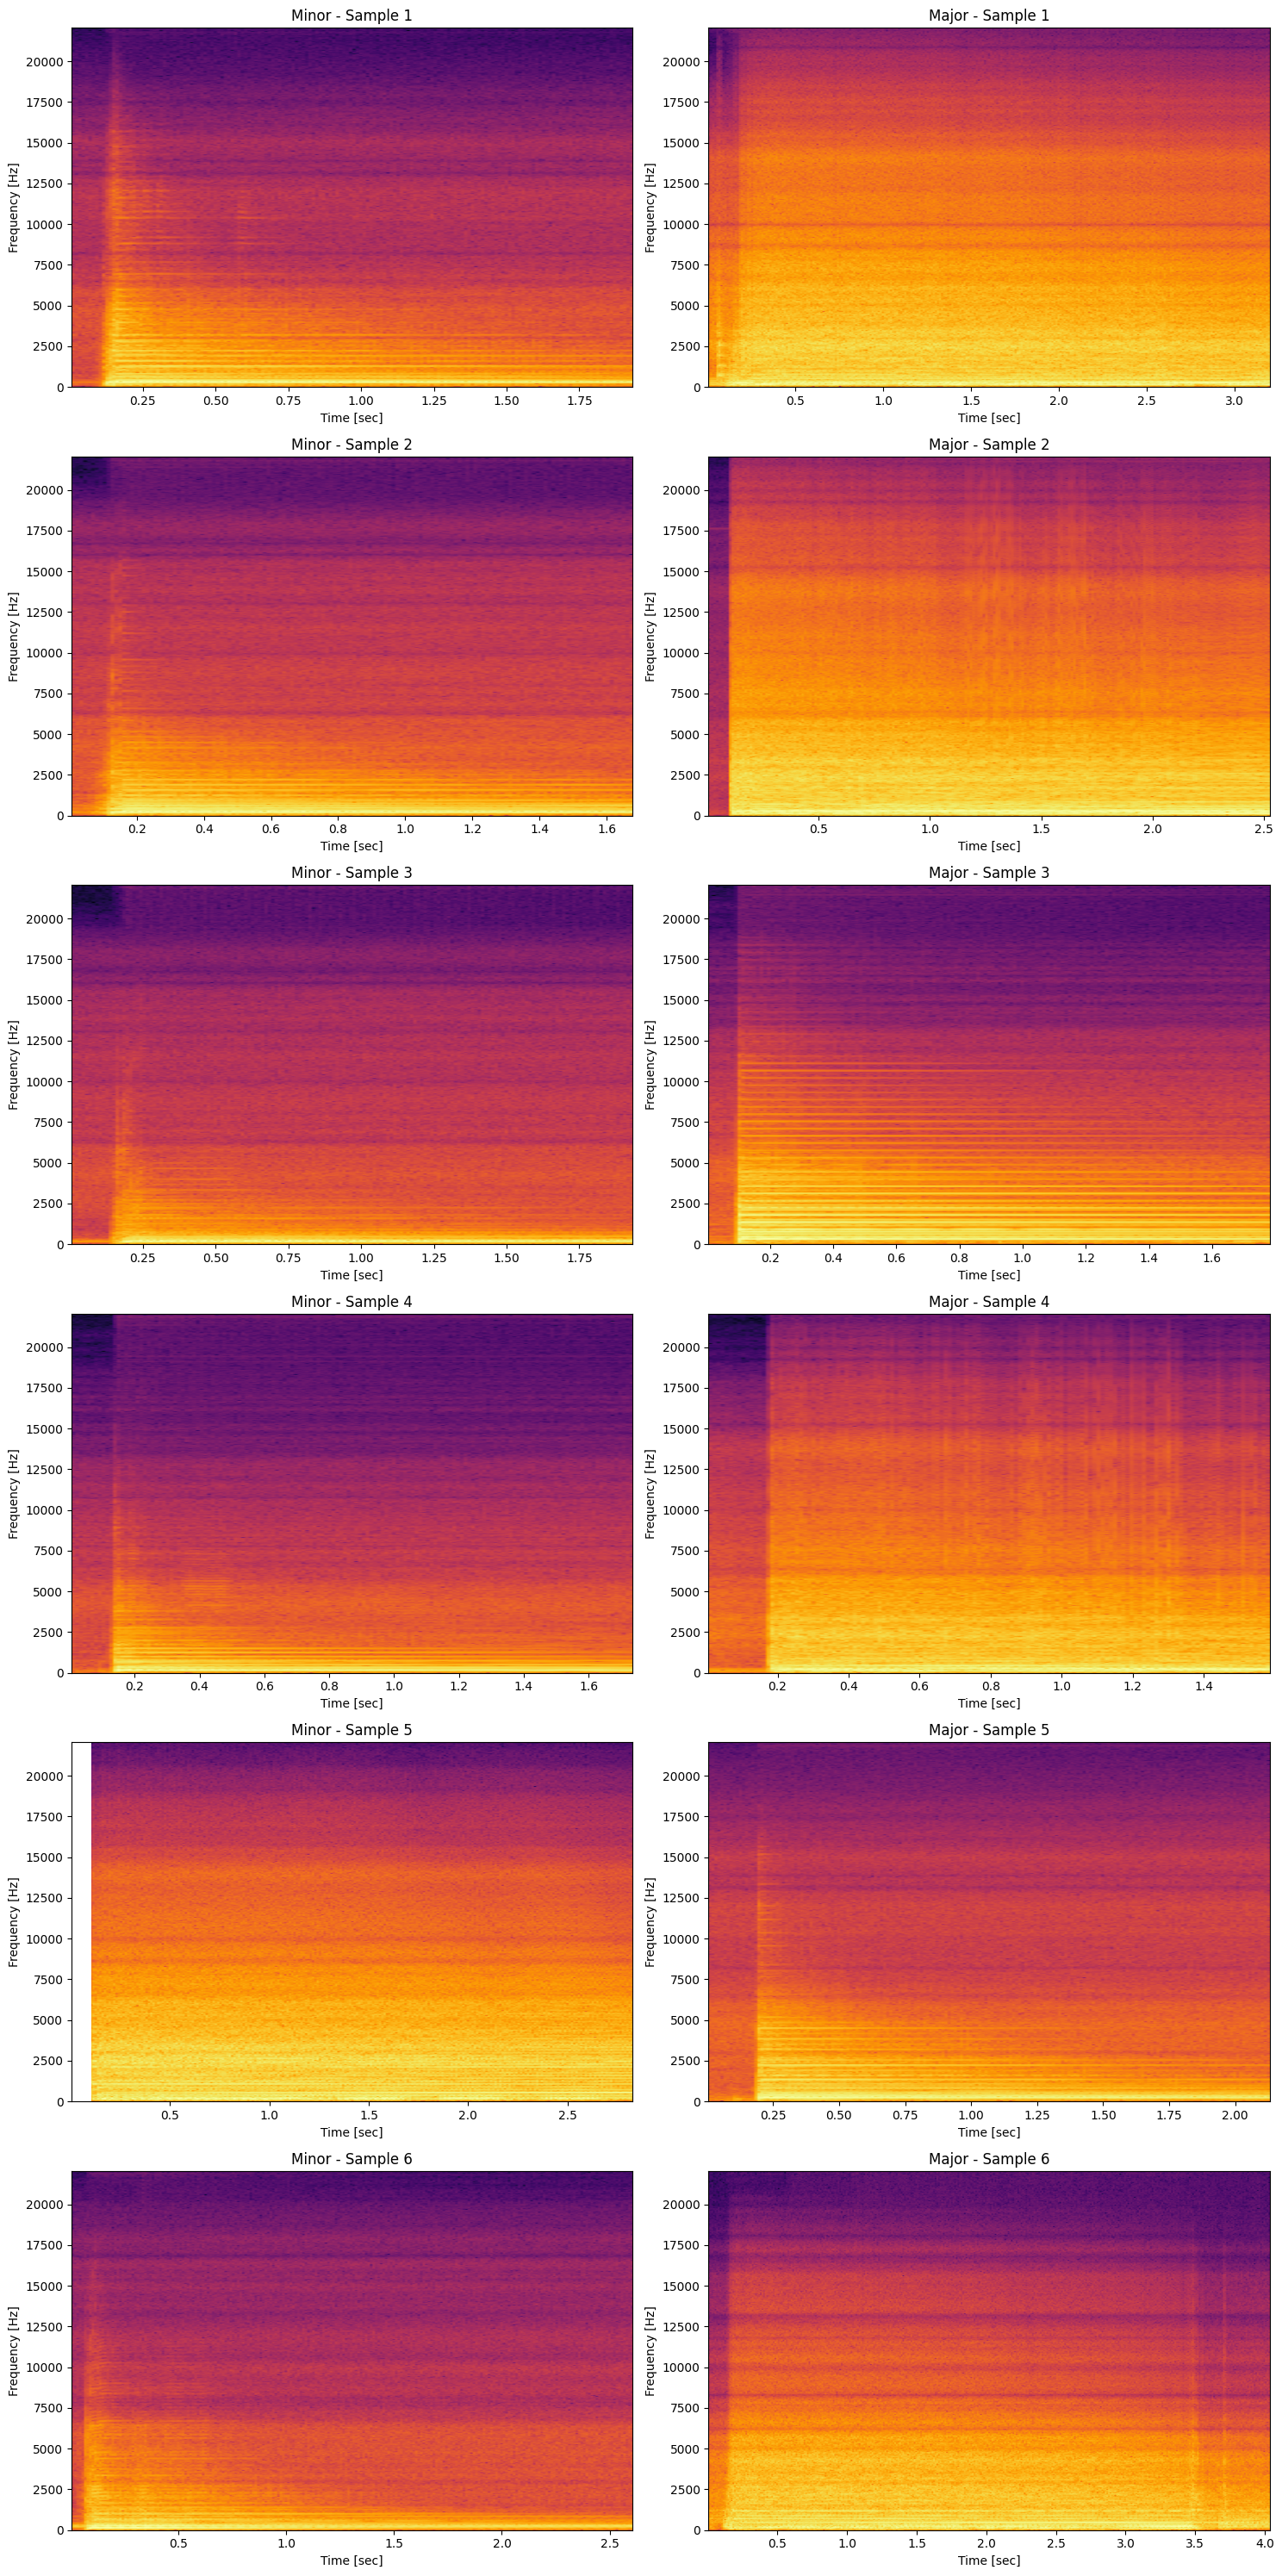

In [12]:
print_multi_spectrogram(data, 6)

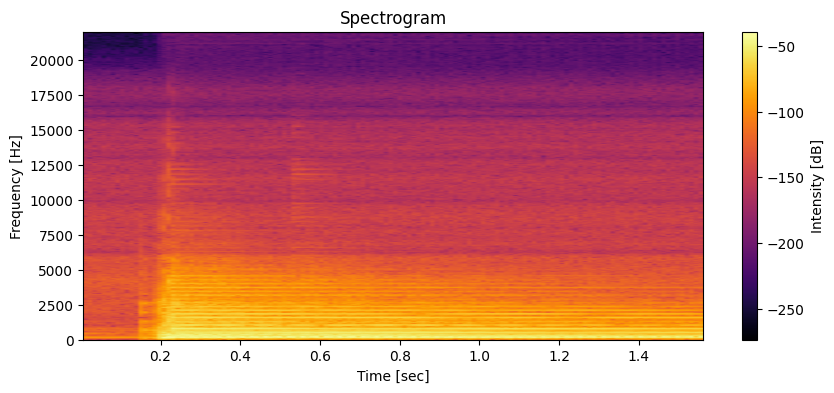

In [60]:
minor_example = data[data['class'] == 'minor'].sample(1).file_path.iloc[0]
print_single_spectrogram(minor_example)
play_audio(minor_example)

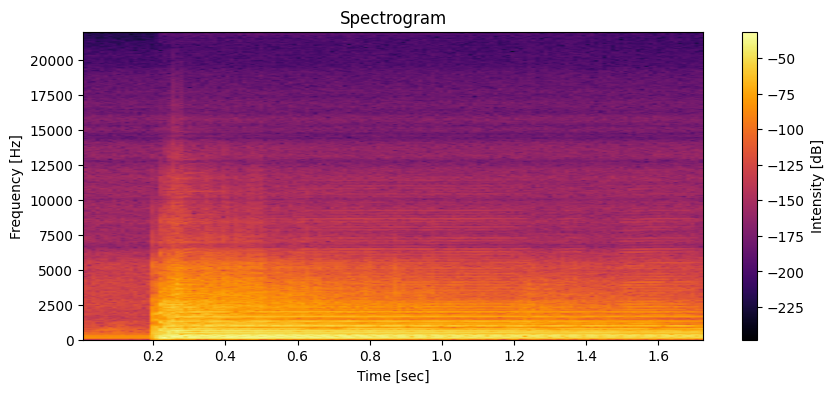

In [136]:
major_example = data[data['class'] == 'major'].sample(1).file_path.iloc[0]
print_single_spectrogram(major_example)
play_audio(major_example)

In [95]:
features_df['mean_mfcc'] = features_df.mfcc.apply(np.mean)

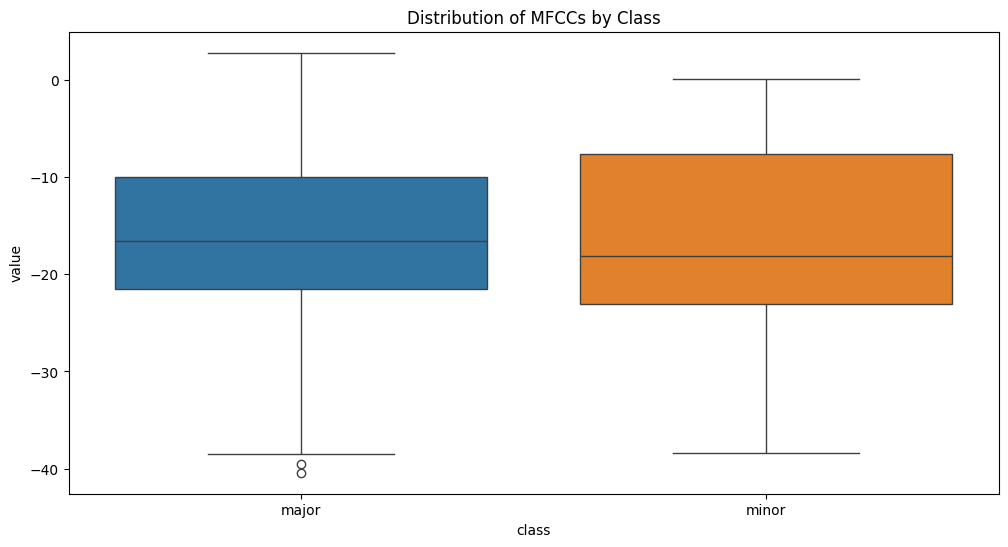

In [85]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='value', hue='class', 
            data=pd.melt(features_df[['mean_mfcc', 'class']], id_vars=['class']))
plt.title('Distribution of MFCCs by Class')
plt.show()


In [92]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(features_df[['mean_mfcc']])

KMeans(n_clusters=2, random_state=42)

In [105]:
mfcc_df = pd.DataFrame(features_df['mfcc'].to_list(), columns=[f'mfcc_{i+1}' for i in range(13)])
mfcc_df['class'] = features_df['class']

In [126]:
class_mapping = {'major': 0, 'minor': 1}
mfcc_df['class'] = mfcc_df['class'].map(class_mapping)

In [109]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(mfcc_df[mfcc_df.columns[:-1]])

In [127]:
kmeans = KMeans(n_clusters=2, random_state=42)  # Assuming you want to cluster into 2 groups
mfcc_df['cluster'] = kmeans.fit_predict(X)

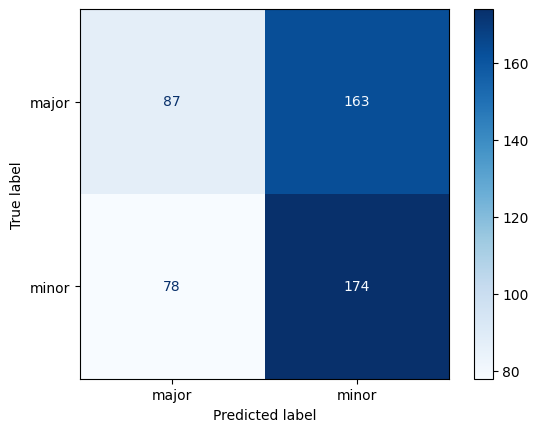

In [132]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(mfcc_df['class'], mfcc_df['cluster'])

# Assuming 'class' column is your actual class labels
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(mfcc_df['class'], mfcc_df['cluster']), 
                              display_labels=['major', 'minor'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [119]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

# Create a new DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [121]:
pca_df['class'] = mfcc_df['class']

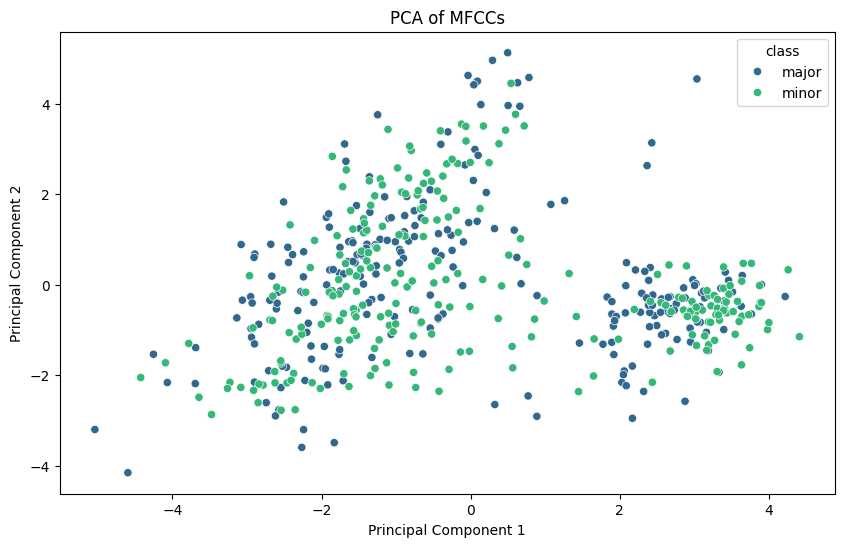

In [122]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df, palette='viridis')
plt.title('PCA of MFCCs')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [146]:
waveform, _ = torchaudio.load(data.file_path.iloc[0])
waveform = waveform[:,:30000].mean(axis = 0)
specgram = torchaudio.transforms.Spectrogram()(waveform)


In [147]:
specgram

tensor([[2.2238e-03, 1.4121e-04, 2.5046e-06,  ..., 1.6637e+00, 2.8696e-01,
         7.6318e+01],
        [1.2925e-03, 3.9888e-04, 4.0643e-05,  ..., 3.2898e+01, 2.4968e+01,
         1.0349e+02],
        [1.2137e-05, 6.5130e-04, 1.0670e-05,  ..., 8.0611e+01, 1.7200e+01,
         4.5408e+01],
        ...,
        [1.7177e-10, 0.0000e+00, 8.3077e-18,  ..., 3.7526e-14, 2.5935e-13,
         3.6836e-06],
        [1.7161e-10, 2.1684e-19, 8.6736e-19,  ..., 1.9984e-15, 5.6843e-14,
         3.6790e-06],
        [1.7156e-10, 1.9516e-18, 4.8925e-18,  ..., 1.4211e-14, 1.2790e-13,
         3.6781e-06]])

In [14]:
features_df

mfcc  \
0    [-476.76318, 151.93126, 40.751, 32.72851, 24.6...   
1    [-335.80048, 179.6296, 55.25127, 31.447277, 13...   
2    [-208.60654, 157.71774, -48.672695, 61.206535,...   
3    [-171.53383, 132.51572, -62.749226, 48.26567, ...   
4    [-319.41586, 170.46034, -26.558022, 46.63934, ...   
..                                                 ...   
497  [-144.77063, 148.93988, -58.836235, 65.71776, ...   
498  [-156.25069, 153.90326, -49.931843, 81.31434, ...   
499  [-416.9574, 212.89882, -32.472538, 25.19351, 8...   
500  [-185.48212, 163.50858, -60.28076, 61.0207, -2...   
501  [-156.6845, 143.80418, -40.124577, 59.034782, ...   

                                                chroma  \
0    [0.07109754, 0.23662832, 0.119075544, 0.034319...   
1    [0.99775046, 0.5311837, 0.12067461, 0.02790163...   
2    [0.17962024, 0.4132284, 0.14981933, 0.1057, 0....   
3    [0.4343349, 0.2425447, 0.3072836, 0.47937635, ...   
4    [0.09210917, 0.16642003, 0.56865525, 0.2390682...   
..                                                 ...   
497  [0.08916105, 0.13987347, 0.31143254, 0.1392173...   
498  [0.5577294, 0.29450554, 0.11451994, 0.1558281,...   
499  [0.9349034, 0.337534, 0.04312946, 0.1043724, 0...   
500  [0.37836492, 0.25652578, 0.64891434, 0.2697478...   
501  [0.07367849, 0.084620215, 0.14025067, 0.115343...   

                                     spectral_contrast  \
0    [41.0489623476132, 26.657021585276254, 31.1123...   
1    [39.272527931767556, 23.48082262123975, 26.503...   
2    [36.36881600606326, 19.86893437500212, 20.1283...   
3    [35.62044366553172, 20.570914298469166, 22.997...   
4    [29.648201390817977, 23.27541713218227, 29.477...   
..                                                 ...   
497  [34.869066298649415, 15.95737673665865, 19.837...   
498  [36.44681307055399, 16.934301205993293, 16.043...   
499  [40.93154792677927, 21.06649622903338, 25.2357...   
500  [33.79610004897452, 16.44902166738816, 18.8295...   
501  [38.068726187606984, 19.349780841500472, 15.38...   

         zero_crossing_rate            rms  class  
0     [0.02427658525485437]  [0.050102513]  major  
1     [0.01930642985611511]   [0.15900731]  major  
2    [0.041716202445652176]   [0.11932669]  major  
3     [0.10549618153089887]   [0.08774114]  major  
4    [0.040359724813432835]  [0.102848634]  major  
..                      ...            ...    ...  
497   [0.06228215144230769]   [0.13583204]  minor  
498   [0.04816828547297297]   [0.13149399]  minor  
499  [0.048528645833333335]  [0.031853683]  minor  
500    [0.0748630099826389]    [0.1051249]  minor  
501   [0.03973431959219858]   [0.18435925]  minor  

[502 rows x 6 columns]